In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [38]:
data = pd.read_csv('co2-ppm.csv', sep =',', index_col=['Month'], parse_dates=['Month'])

In [39]:
data.columns = ['CO2']

In [41]:
data.head(5)

,CO2
Month,
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17


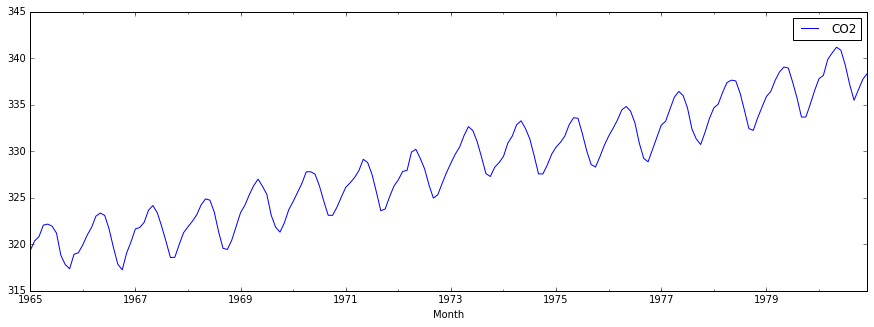

In [44]:
plt.figure(figsize(15,5))
    
data.plot()